In [ ]:
# ================================================================
# 0. Environment initialization (run this FIRST in Colab)
# ================================================================

# Clean up conflicting packages that require NumPy>=2 (they break PennyLane on Colab)
!pip uninstall -y jax jaxlib opencv-python opencv-python-headless opencv-contrib-python shap pytensor albumentations albucore >/dev/null 2>&1

# Install a known-compatible stack for PennyLane + Torch + Captum
!pip install numpy==1.26.4 --quiet
!pip install autoray==0.6.7 --quiet
!pip install pennylane==0.35.1 --quiet
!pip install torch torchvision torchaudio --quiet
!pip install captum matplotlib --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires jax>=0.1.72, which is not installed.
dopamine-rl 4.1.2 requires jaxlib>=0.1.51, which is not installed.
dopamine-rl 4.1.2 requires opencv-python>=3.4.8.29, which is not installed.
flax 0.10.7 requires jax>=0.6.0, which is not installed.
optax 0.2.6 requires jax>=0.5.3, which is not installed.
optax 0.2.6 requires jaxlib>=0.5.3, which is not installed.
pymc 5.26.1 requires pytensor<2.36,>=2.35.0, which is not installed.
orbax-checkpoint 0.11.28 requires jax>=0.6.0, which is not installed.
chex 0.1.90 requires jax>=0.4.27, which is not installed.
chex 0.1.90 requires jaxlib>=0.4.27, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl

Train: torch.Size([320, 1, 8, 8]) Test: torch.Size([80, 1, 8, 8])
=== Training main ML ===
=== Training main QML ===
[Main] ML  clean/adv = 1.000/0.000
[Main] QML clean/adv = 1.000/0.750

===== Monte-Carlo 10-run =====
▶ Run 1/10 ...
    ML:  clean=1.000, adv=0.000
    QML: clean=1.000, adv=0.538
▶ Run 2/10 ...
    ML:  clean=1.000, adv=1.000
    QML: clean=1.000, adv=0.538
▶ Run 3/10 ...
    ML:  clean=1.000, adv=0.000
    QML: clean=1.000, adv=0.538
▶ Run 4/10 ...
    ML:  clean=1.000, adv=0.538
    QML: clean=1.000, adv=0.562
▶ Run 5/10 ...
    ML:  clean=1.000, adv=0.237
    QML: clean=1.000, adv=0.538
▶ Run 6/10 ...
    ML:  clean=1.000, adv=0.538
    QML: clean=1.000, adv=0.663
▶ Run 7/10 ...
    ML:  clean=1.000, adv=0.538
    QML: clean=1.000, adv=0.538
▶ Run 8/10 ...
    ML:  clean=1.000, adv=0.112
    QML: clean=1.000, adv=0.538
▶ Run 9/10 ...
    ML:  clean=1.000, adv=0.538
    QML: clean=1.000, adv=0.550
▶ Run 10/10 ...
    ML:  clean=1.000, adv=0.000
    QML: clean=1.000, 

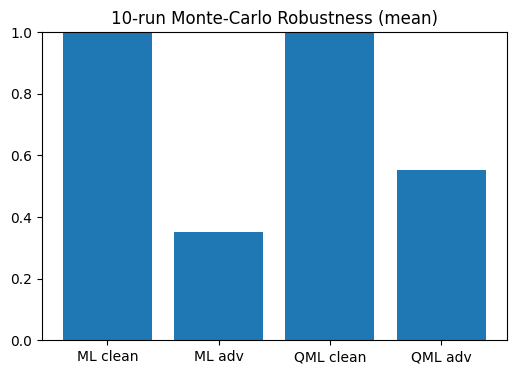

In [ ]:
# ================================================================
# 第二格（新版）：ML/QML Fair Training + 10-run Monte-Carlo
# ================================================================

import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

# ================================================================
# 1. Dataset
# ================================================================
def make_plusminus_dataset(n_samples=200, img_size=8, noise_std=0.08, seed=42):
    rng = np.random.default_rng(seed)
    X, y = [], []
    for _ in range(n_samples):
        img_plus = np.zeros((img_size, img_size))
        img_plus[img_size//2, :] = 1
        img_plus[:, img_size//2] = 1
        img_plus += noise_std * rng.standard_normal((img_size, img_size))

        img_minus = np.zeros((img_size, img_size))
        img_minus[img_size//2, :] = 1
        img_minus += noise_std * rng.standard_normal((img_size, img_size))

        X.append(img_plus); y.append(0)
        X.append(img_minus); y.append(1)

    X = np.clip(np.array(X), 0.0, 1.0)
    return (
        torch.tensor(X, dtype=torch.float32).unsqueeze(1),
        torch.tensor(np.array(y), dtype=torch.long),
    )

X, y = make_plusminus_dataset(200, 8, noise_std=0.08)

perm = torch.randperm(len(X))
X, y = X[perm], y[perm]
n_train = int(0.8 * len(X))
X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

print("Train:", X_train.shape, "Test:", X_test.shape)


# ================================================================
# 2. Shared CNN backbone（完全公平）
# ================================================================
class CNNBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.AvgPool2d(2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)              # 16×4×4
        x = F.relu(self.conv2(x))
        x = self.pool(x)              # 32×2×2
        x = x.view(x.size(0), -1)     # 128
        return x

feat_dim = 32 * 2 * 2


# ================================================================
# 3. ML & QML models（公平 capacity）
# ================================================================
class ClassicalCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = CNNBackbone()
        self.fc1 = nn.Linear(feat_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 2)

    def forward(self, x):
        x = self.backbone(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


# --- Quantum model ---
n_qubits, n_layers = 4, 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

weight_shapes = {"weights": (n_layers, n_qubits, 3)}
qml_layer = qml.qnn.TorchLayer(qnode, weight_shapes)

class QuantumCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = CNNBackbone()
        self.fc_feat = nn.Linear(feat_dim, n_qubits)
        self.quantum = qml_layer
        self.fc_out = nn.Linear(2, 2)

    def forward(self, x):
        x = self.backbone(x)
        x = torch.tanh(self.fc_feat(x))
        x = self.quantum(x)
        return self.fc_out(x)


# ================================================================
# 4. Training / Evaluation / PGD Attack
# ================================================================
def train(model, opt, X, y, epochs=60):
    model.train()
    for ep in range(epochs):
        perm = torch.randperm(len(X))
        for i in range(0, len(X), 32):
            idx = perm[i:i+32]
            x_b, y_b = X[idx], y[idx]
            opt.zero_grad()
            out = model(x_b)
            loss = F.cross_entropy(out, y_b)
            loss.backward()
            opt.step()


def evaluate(model, X, y):
    model.eval()
    pred = torch.argmax(model(X), 1)
    return (pred == y).float().mean().item()


def pgd_attack(model, X, y, eps=0.25, alpha=0.04, steps=10):
    x_adv = X.clone().detach()
    for _ in range(steps):
        x_adv.requires_grad_()
        out = model(x_adv)
        loss = F.cross_entropy(out, y)
        loss.backward()
        with torch.no_grad():
            x_adv = x_adv + alpha * x_adv.grad.sign()
            x_adv = torch.min(torch.max(x_adv, X - eps), X + eps)
            x_adv = torch.clamp(x_adv, 0, 1)
    return x_adv.detach()


# ================================================================
# 5. 主模型訓練（給 XAI 使用）
# ================================================================
ml_model = ClassicalCNN()
qml_model = QuantumCNN()

opt_ml  = optim.Adam(ml_model.parameters(),  lr=0.01)
opt_qml = optim.Adam(qml_model.parameters(), lr=0.005)

print("=== Training main ML ===")
train(ml_model, opt_ml, X_train, y_train, epochs=80)
print("=== Training main QML ===")
train(qml_model,opt_qml,X_train,y_train,epochs=80)

ml_clean = evaluate(ml_model, X_test, y_test)
qml_clean = evaluate(qml_model, X_test, y_test)

X_adv_ml  = pgd_attack(ml_model,  X_test, y_test)
X_adv_qml = pgd_attack(qml_model, X_test, y_test)

ml_adv = evaluate(ml_model,  X_adv_ml,  y_test)
qml_adv = evaluate(qml_model, X_adv_qml, y_test)

print(f"[Main] ML  clean/adv = {ml_clean:.3f}/{ml_adv:.3f}")
print(f"[Main] QML clean/adv = {qml_clean:.3f}/{qml_adv:.3f}")


# ================================================================
# 6. Monte-Carlo 10-run Benchmark（自動訓練 10 次）
# ================================================================
def run_once(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    ml = ClassicalCNN()
    qm = QuantumCNN()

    opt_ml = optim.Adam(ml.parameters(), lr=0.01)
    opt_qm = optim.Adam(qm.parameters(), lr=0.005)

    train(ml, opt_ml, X_train, y_train, epochs=40)
    train(qm, opt_qm, X_train, y_train, epochs=40)

    clean_ml = evaluate(ml, X_test, y_test)
    clean_qm = evaluate(qm, X_test, y_test)

    adv_ml = evaluate(ml, pgd_attack(ml, X_test, y_test), y_test)
    adv_qm = evaluate(qm, pgd_attack(qm, X_test, y_test), y_test)

    return clean_ml, adv_ml, clean_qm, adv_qm


N_RUNS = 10
results = []

print("\n===== Monte-Carlo 10-run =====")
for i in range(N_RUNS):
    print(f"▶ Run {i+1}/{N_RUNS} ...")
    clean_ml, adv_ml, clean_qm, adv_qm = run_once(i)
    print(f"    ML:  clean={clean_ml:.3f}, adv={adv_ml:.3f}")
    print(f"    QML: clean={clean_qm:.3f}, adv={adv_qm:.3f}")
    results.append([clean_ml, adv_ml, clean_qm, adv_qm])

results = torch.tensor(results)
ml_clean_mean  = results[:,0].mean().item()
ml_adv_mean    = results[:,1].mean().item()
qml_clean_mean = results[:,2].mean().item()
qml_adv_mean   = results[:,3].mean().item()

print("\n===== Summary (mean over 10 runs) =====")
print(f"ML  clean={ml_clean_mean:.3f}, adv={ml_adv_mean:.3f}")
print(f"QML clean={qml_clean_mean:.3f}, adv={qml_adv_mean:.3f}")

# Bar chart summary
plt.figure(figsize=(6,4))
labels = ["ML clean","ML adv","QML clean","QML adv"]
values = [ml_clean_mean, ml_adv_mean, qml_clean_mean, qml_adv_mean]
plt.bar(labels, values)
plt.ylim(0,1)
plt.title("10-run Monte-Carlo Robustness (mean)")
plt.show()


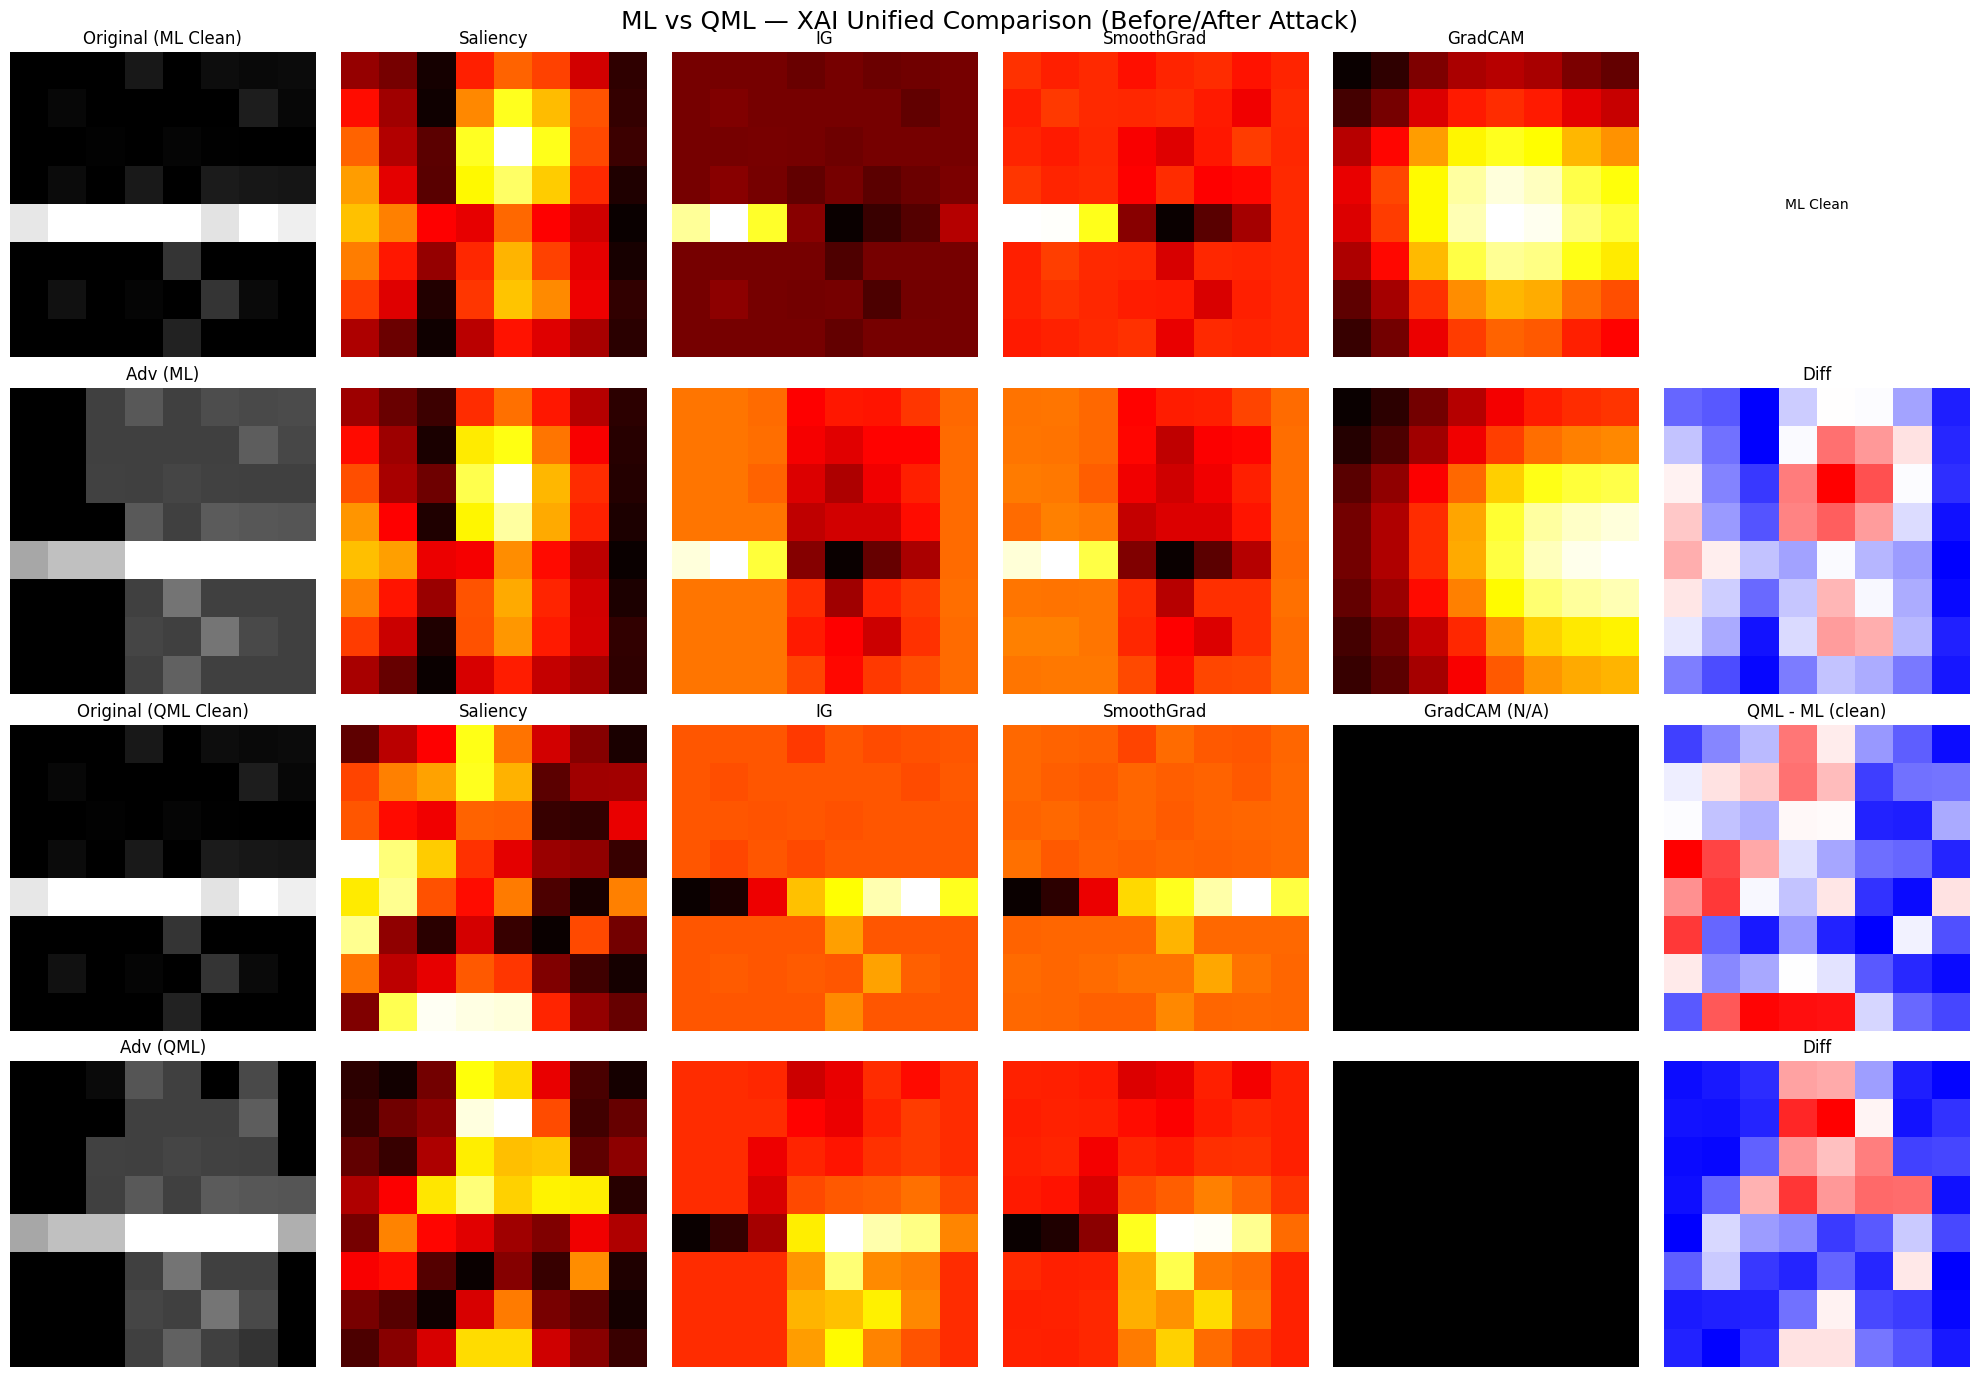

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel, LayerGradCam

# ==============================================
# Wrappers for Captum (softmax outputs)
# ==============================================
def ml_forward(x):
    ml_model.eval()
    return F.softmax(ml_model(x), dim=1)

def qml_forward(x):
    qml_model.eval()
    return F.softmax(qml_model(x), dim=1)

# ==============================================
# XAI Functions
# ==============================================
def explain_saliency_ig(model_forward, img, target):
    img = img.clone().detach().requires_grad_(True)

    sal = Saliency(model_forward)
    attr_sal = sal.attribute(img, target=target).detach().cpu().numpy()

    ig = IntegratedGradients(model_forward)
    baseline = torch.zeros_like(img)
    attr_ig = ig.attribute(img, baseline, target=target, n_steps=30).detach().cpu().numpy()

    return attr_sal.squeeze(), attr_ig.squeeze()

def explain_smoothgrad(model_forward, img, target):
    img = img.clone().detach().requires_grad_(True)

    ig = IntegratedGradients(model_forward)
    nt = NoiseTunnel(ig)

    attr_sg = nt.attribute(img, nt_type="smoothgrad",
                           target=target, nt_samples=20, stdevs=0.1)

    return attr_sg.detach().cpu().numpy().squeeze()

def explain_gradcam_ml(img, target):
    img = img.clone().detach().requires_grad_(True)

    # Layer selection (公平性：使用 conv2)
    target_layer = ml_model.backbone.conv2

    layer_gc = LayerGradCam(ml_model, target_layer)
    attr = layer_gc.attribute(img, target=target)

    # Upsample to 8x8
    attr = F.interpolate(attr, size=(8, 8), mode='bilinear', align_corners=False)

    return attr.detach().cpu().numpy().squeeze()

# ==============================================
# Select a test sample to visualize
# ==============================================
idx = 0
x_orig = X_test[idx:idx+1]
x_adv_ml = X_adv_ml[idx:idx+1]
x_adv_qml = X_adv_qml[idx:idx+1]
y_true = y_test[idx].item()

# ==============================================
# ML — Before / After Attack
# ==============================================
sal_ml_o, ig_ml_o = explain_saliency_ig(ml_forward, x_orig,   y_true)
sg_ml_o           = explain_smoothgrad(ml_forward, x_orig,   y_true)
gc_ml_o           = explain_gradcam_ml(x_orig,     y_true)

sal_ml_a, ig_ml_a = explain_saliency_ig(ml_forward, x_adv_ml, y_true)
sg_ml_a           = explain_smoothgrad(ml_forward, x_adv_ml, y_true)
gc_ml_a           = explain_gradcam_ml(x_adv_ml,   y_true)


# ==============================================
# QML — Before / After Attack (no GradCAM)
# ==============================================
sal_q_o, ig_q_o = explain_saliency_ig(qml_forward, x_orig, y_true)
sg_q_o          = explain_smoothgrad(qml_forward, x_orig, y_true)

sal_q_a, ig_q_a = explain_saliency_ig(qml_forward, x_adv_qml, y_true)
sg_q_a          = explain_smoothgrad(qml_forward, x_adv_qml, y_true)


# ==============================================
# Unified Plot (ML vs QML, Before vs After)
# ==============================================
fig, axs = plt.subplots(4, 6, figsize=(20, 14))
plt.suptitle("ML vs QML — XAI Unified Comparison (Before/After Attack)", fontsize=18)

# --------------------------
# Row 1: ML — Clean
# --------------------------
axs[0,0].imshow(x_orig[0,0].cpu(), cmap='gray')
axs[0,0].set_title("Original (ML Clean)"); axs[0,0].axis('off')

axs[0,1].imshow(sal_ml_o, cmap='hot'); axs[0,1].set_title("Saliency"); axs[0,1].axis('off')
axs[0,2].imshow(ig_ml_o,  cmap='hot'); axs[0,2].set_title("IG");       axs[0,2].axis('off')
axs[0,3].imshow(sg_ml_o,  cmap='hot'); axs[0,3].set_title("SmoothGrad");axs[0,3].axis('off')
axs[0,4].imshow(gc_ml_o,  cmap='hot'); axs[0,4].set_title("GradCAM");   axs[0,4].axis('off')

axs[0,5].text(0.5,0.5,"ML Clean",ha='center',va='center'); axs[0,5].axis('off')

# --------------------------
# Row 2: ML — Adv
# --------------------------
axs[1,0].imshow(x_adv_ml[0,0].cpu(), cmap='gray')
axs[1,0].set_title("Adv (ML)"); axs[1,0].axis('off')

axs[1,1].imshow(sal_ml_a, cmap='hot'); axs[1,1].axis('off')
axs[1,2].imshow(ig_ml_a , cmap='hot'); axs[1,2].axis('off')
axs[1,3].imshow(sg_ml_a , cmap='hot'); axs[1,3].axis('off')
axs[1,4].imshow(gc_ml_a , cmap='hot'); axs[1,4].axis('off')

axs[1,5].imshow(np.abs(sal_ml_a - sal_ml_o), cmap='bwr')
axs[1,5].set_title("Diff"); axs[1,5].axis('off')

# --------------------------
# Row 3: QML — Clean
# --------------------------
axs[2,0].imshow(x_orig[0,0].cpu(), cmap='gray')
axs[2,0].set_title("Original (QML Clean)"); axs[2,0].axis('off')

axs[2,1].imshow(sal_q_o, cmap='hot'); axs[2,1].set_title("Saliency"); axs[2,1].axis('off')
axs[2,2].imshow(ig_q_o , cmap='hot'); axs[2,2].set_title("IG");       axs[2,2].axis('off')
axs[2,3].imshow(sg_q_o , cmap='hot'); axs[2,3].set_title("SmoothGrad");axs[2,3].axis('off')
axs[2,4].imshow(np.zeros((8,8)), cmap='gray'); axs[2,4].set_title("GradCAM (N/A)"); axs[2,4].axis('off')

axs[2,5].imshow(np.abs(sal_q_o - sal_ml_o), cmap='bwr')
axs[2,5].set_title("QML - ML (clean)"); axs[2,5].axis('off')

# --------------------------
# Row 4: QML — Adv
# --------------------------
axs[3,0].imshow(x_adv_qml[0,0].cpu(), cmap='gray')
axs[3,0].set_title("Adv (QML)"); axs[3,0].axis('off')

axs[3,1].imshow(sal_q_a, cmap='hot'); axs[3,1].axis('off')
axs[3,2].imshow(ig_q_a , cmap='hot'); axs[3,2].axis('off')
axs[3,3].imshow(sg_q_a , cmap='hot'); axs[3,3].axis('off')
axs[3,4].imshow(np.zeros((8,8)), cmap='gray'); axs[3,4].axis('off')

axs[3,5].imshow(np.abs(sal_q_a - sal_q_o), cmap='bwr')
axs[3,5].set_title("Diff"); axs[3,5].axis('off')

plt.tight_layout()
plt.show()
